ISLA: Tenerife, WINDOW = 9
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=9, forecast_length=1, share_thetas=False) at @5571247040
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=9, forecast_length=1, share_thetas=False) at @6412695600
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=9, forecast_length=1, share_thetas=False) at @6412691856
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=9, forecast_length=1, share_thetas=False) at @6407670960
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=9, forecast_length=1, share_thetas=False) at @6412690992
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=9, forecast_length=1, share_thetas=False) at @6412690560
Epoch [500/20000], Train Loss: 50838.7695, Val Loss: 65537.5859

Epoch [1000/20000], Train Loss: 41837.5000, Val Loss: 57565.

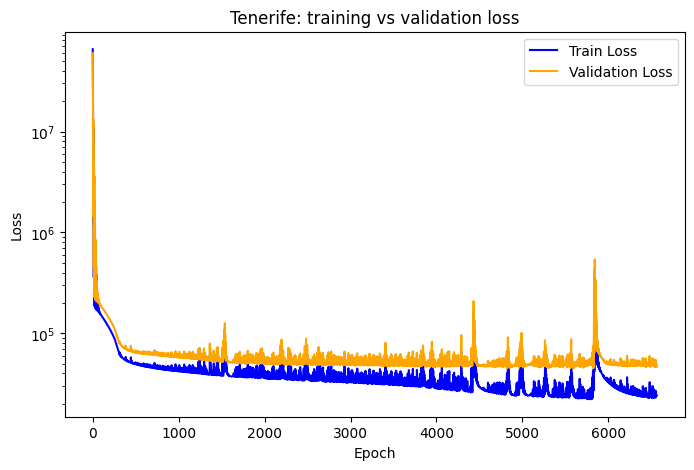

Evaluation Metrics:
R2: 0.8055599734972415
MAE: 104.4372
MSE: 33578.9257
RMSE: 183.2455
R2: 0.8056
MAPE: 0.0122
sMAPE: 0.0121




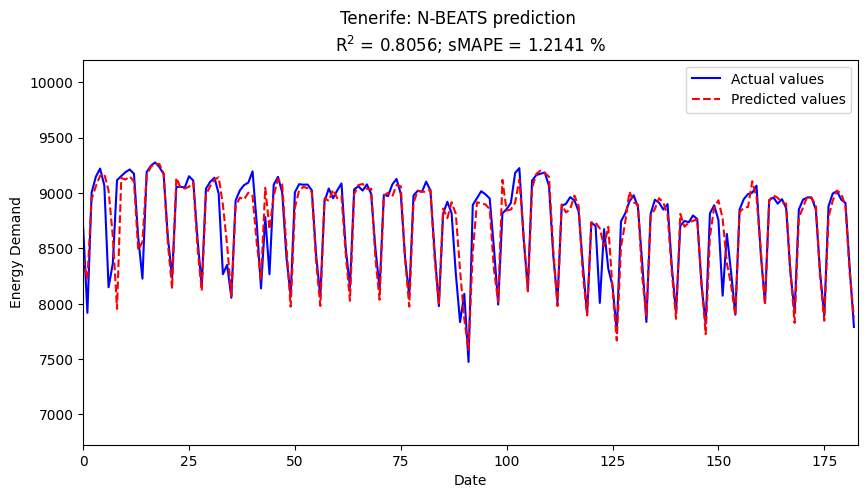

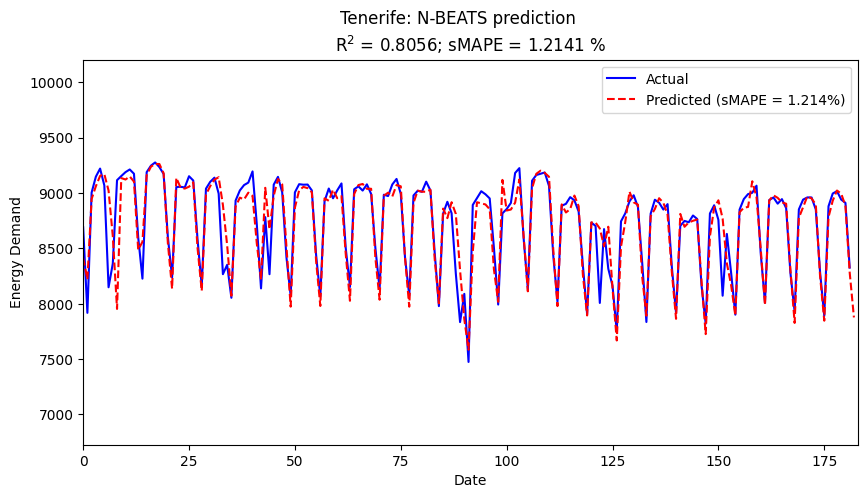

In [9]:
# Imports
import random

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.animation as animation

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler

from src.utils import metrics
from src.utils import data_loader as d
from src.utils import models
from src.utils import sliding_window as s

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# Load Data
islas_dfs = d.local_data_loader(verbose=False)

# islas = ['Tenerife', 'Gran Canaria', 'Lanzarote', 'Fuerteventura', 'La Palma', 'La Gomera', 'El Hierro']
# windows = [9, 11, 11, 8, 7, 6, 19]

islas = ['Tenerife']
windows = [9]

for isla, window in zip(islas, windows):

        print(f'ISLA: {isla}, WINDOW = {window}')

        # Extract demand value
        demand = islas_dfs[isla]['OBS_VALUE'].values.reshape(-1,1) # data['energy'].values.reshape(-1, 1)

        # Data scaling
        # scaler = MaxAbsScaler()
        # demand_scaled = scaler.fit_transform(demand)

        # Training and validation
        train_size = 1460  # First 4 years for training/validation
        val_size = int(0.2 * train_size)  # 20% of training data for validation
        window_size = window 

        # Split into training, validation, and test sets
        train_data = demand[:train_size - val_size]
        val_data = demand[train_size - val_size:train_size]
        test_data = demand[train_size - window_size:]

        # Sliding window sequences for training and validation
        train_sequences, train_targets = s.create_sequences(train_data, window_size)
        val_sequences, val_targets = s.create_sequences(val_data, window_size)

        # Convert to PyTorch tensors
        train_sequences = torch.tensor(train_sequences, dtype=torch.float32)
        train_targets = torch.tensor(train_targets, dtype=torch.float32)
        val_sequences = torch.tensor(val_sequences, dtype=torch.float32)
        val_targets = torch.tensor(val_targets, dtype=torch.float32)
        # Model training and validation
        from nbeats_pytorch.model import NBeatsNet 

        model = NBeatsNet(
            stack_types=("generic", "generic"),
            forecast_length=1,
            backcast_length=window_size,
            hidden_layer_units=128
        )

        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=1e-3)

        train_losses, val_losses = [], []
        best_val_loss = float('inf')
        stopping_counter = 0
        early_stopping = True

        num_epochs = 20_000 
        early_stopping_patience = 1_000

        for epoch in range(num_epochs):
            # Training step
            model.train()
            optimizer.zero_grad()
            _, output = model(train_sequences)
            train_loss = criterion(output, train_targets)
            train_loss.backward()
            optimizer.step()

            # Validation step
            model.eval()
            with torch.no_grad():
                _, val_output = model(val_sequences)
                val_loss = criterion(val_output, val_targets)

            train_losses.append(train_loss.item())
            val_losses.append(val_loss.item())
            if val_loss.item() < best_val_loss:
                best_val_loss = val_loss.item()
                stopping_counter = 0
            else:
                stopping_counter += 1

            if early_stopping and stopping_counter >= early_stopping_patience:
                # print("Early stopping triggered!")
                break

            if (epoch + 1) % 500 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}\n')

        plt.figure(figsize=(8, 5))
        plt.plot(train_losses, label='Train Loss', color='blue')
        plt.plot(val_losses, label='Validation Loss', color='orange')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.yscale('log')
        plt.title(f'{isla}: training vs validation loss')
        plt.legend()
        plt.show()

        # Prediction
        test_sequences, test_targets = s.create_sequences(test_data, window_size)
        test_sequences = torch.tensor(test_sequences, dtype=torch.float32)
        test_targets = torch.tensor(test_targets, dtype=torch.float32)

        # Initialize lists for storing predictions
        online_predictions = []
        actual_values = []

        # Define online optimizer and loss function
        online_optimizer = optim.Adam(model.parameters(), lr=1e-6)
        criterion = nn.MSELoss()

        # ======= 9. Online Prediction and Evaluation =======
        for i in range(len(test_sequences)):
            x = test_sequences[i].unsqueeze(0)

            # Model inference
            model.eval()
            with torch.no_grad():
                pred = model(x)[1]  # Extract the forecast output
            online_predictions.append(pred.item())
            actual_values.append(test_targets[i].item())

            # Online learning step
            model.train()
            online_optimizer.zero_grad()
            pred_online = model(x)[1]  # Extract forecast again for training
            loss_online = criterion(pred_online, test_targets[i].unsqueeze(0))
            loss_online.backward()
            online_optimizer.step()

        # online_predictions_inv = scaler.inverse_transform(np.array(online_predictions).reshape(-1, 1)).flatten()
        # actual_values_inv = scaler.inverse_transform(np.array(actual_values).reshape(-1, 1)).flatten()

        metrics_result = metrics.all_metrics(actual_values, online_predictions)
        print("Evaluation Metrics:")
        print(f"R2: {metrics_result['R2']}")
        for metric, value in metrics_result.items():
            print(f"{metric}: {value:.4f}")
        print('\n')

        # Animation
        test_dates = islas_dfs[isla]['TIME_PERIOD_CODE'].values.reshape(-1,1)

        fig, ax = plt.subplots(figsize=(10, 5))
        plt.suptitle(f'{isla}: N-BEATS prediction')
        ax.set_xlim(0, len(actual_values))
        ax.set_ylim(min(actual_values) * 0.9, max(actual_values) * 1.1)
        ax.set_xlabel("Date")
        ax.set_ylabel("Energy Demand")
        ax.set_title(f"R$^2$ = {metrics_result['R2']:.4f}; sMAPE = {100*metrics_result['sMAPE']:.4f} %")

        ax.plot(actual_values, label = 'Actual values', color = 'blue')
        ax.plot(online_predictions, '--r' ,label = 'Predicted values')

        ax.legend()
        plt.savefig(f'../results/per_island/nbeats_{isla}.png')
        plt.show()
        print('\n')


lag = 5

fig, ax = plt.subplots(figsize=(10, 5))
plt.suptitle(f'{isla}: N-BEATS prediction')
ax.set_xlim(0, len(actual_values))
ax.set_ylim(min(actual_values) * 0.9, max(actual_values) * 1.1)
ax.set_xlabel("Date")
ax.set_ylabel("Energy Demand")
ax.set_title(f"R$^2$ = {metrics_result['R2']:.4f}; sMAPE = {100*metrics_result['sMAPE']:.4f} %")

actual_line, = ax.plot([], [], color='blue', label="Actual")
predicted_line, = ax.plot([], [], color='red', linestyle="dashed", 
                            label=f"Predicted (sMAPE = {100*metrics_result['sMAPE']:.3f}%)")
ax.legend()

# Update function with a lag for predicted values
def update(frame):
    # Update actual values up to current frame
    actual_line.set_data(range(frame), actual_values[:frame])
    
    # Update predicted values with a lead of 'lag' days
    pred_frame = frame + lag
    # Make sure not to exceed available predictions
    if pred_frame > len(online_predictions):
        pred_frame = len(online_predictions)
    predicted_line.set_data(range(pred_frame), online_predictions[:pred_frame])

# Create animation
ani = animation.FuncAnimation(fig, update, frames=len(actual_values), interval=25)

# Save video
ani.save(f"desfase_{isla}.gif", writer="ffmpeg", fps=100)

plt.show()
